# Define the Zernike Polynomials

In [57]:
function R(n::Int64, m::Int64, ρ::Float64, scale::Float64=1E-6)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ/scale)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function Z(n::Int64, m::Int64)
    """We've ommited normalization"""
    function Z_at_point(ρ::Float64, ϕ::Float64)
        if m >= 0
            R(n, m, ρ) * cos(m * ϕ)
        else
            R(n, -m, ρ) * sin(-m * ϕ)
        end
    end
    Z_at_point
end


Z (generic function with 1 method)

In [58]:
function plot_across_disk(f, discretization::Int64, radius::Float64)
    x = y = Array(range(-radius, radius, length=discretization))
    z = zeros(length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > radius^2
                z[i, j] = 0
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                z[i, j] = f(ρ, ϕ)
            end
        end
    end
    x, y, z
end

plot_across_disk (generic function with 1 method)

In [59]:
#ħ = 1.054E-34
# But also ħ=1...

# In John's notes his conditions on n and m are off.
function H_odf(ρ::Float64, ϕ::Float64, t::Float64, μ::Float64, zernike_coefficients::Array, U::Float64=2*π*10E3, ψ::Float64=0., ω::Float64=2*π*43.8E3)
    """ϕ is the phase offset in the lab frame, and is a defining phase for the Zernike polynomial. ψ is a defining 
    phase in the lab frame for the position of the ions.
    
    We have only considered even Zernike terms here."""
    n = length(zernike_coefficients) - 1
    P = reduce(+, [zernike_coefficients[i] * R(n-1, i-1, ρ) for i in Array(range(1, n, step=1))])
    U/2 * sin(-μ*t + ψ + P * cos(n * (ϕ + ω*t) - n * ω * t))
end

H_odf (generic function with 4 methods)

In [60]:
using QuantumOptics
function odf_time_evolution(ρ::Float64, ϕ::Float64, μ::Float64, zernike_coefficients::Array, Γ::Float64=1/62, evolution_time::Float64=50.E-6)
    b = SpinBasis(1//2)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    T = [0:0.1E-6:50.E-6;]
    H(t, ψ) = H_odf(ρ, ϕ, t, μ, zernike_coefficients)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    tout, ρ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    excitation = last(expect(sigmax(b), ρ))
end

odf_time_evolution (generic function with 3 methods)

In [65]:
using Plots
ω = 2*π*43.8E3
zernike = [1, 1, 1, 1, 1, 1, 1]
μ = (length(zernike) - 1) * ω
population(ρ, ϕ) = odf_time_evolution(ρ, ϕ, 0., zernike)
zernike_func(ρ) = reduce(+, [zernike[i] * R(length(zernike)-1, i-1, ρ) for i in Array(range(1, length(zernike), step=1))])

zernike_func (generic function with 1 method)

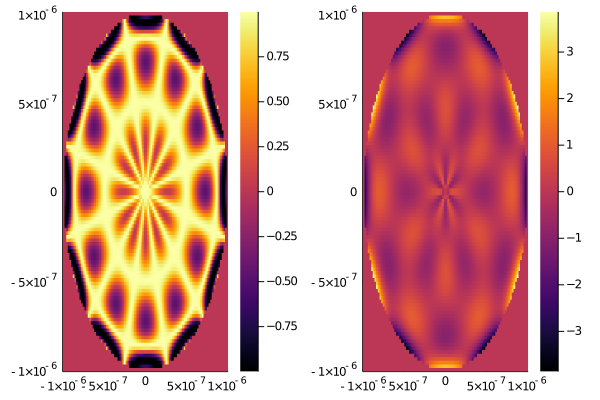

In [66]:
width = 1E-6
# We've also shrank the "size" of the Zernike polynomials from the unit disk to the width disk, so that the crystal
# isn't just exploring some small section. Although the polynomial [1, 1] has no radial dependence, so this doesn't matter.
discretization = 100
# The second and third plots are emphatically different - they should only agree for the 0...0, 1 strings.
plot(
    heatmap(plot_across_disk(population, discretization, width)),
    heatmap(plot_across_disk((ρ, ϕ) -> zernike_func(ρ) * cos((length(zernike)-1)*ϕ), discretization, width)),)
    #heatmap(plot_across_disk((ρ, ϕ) -> reduce(+, [zernike[i]*Z(length(zernike)-1, i - 1)(ρ, ϕ) for i in Array(range(1, length(zernike), step=1))]), discretization, width)))

In [7]:
num_points = 10
x = y = Array(range(-1, 1,length=num_points))
z = zeros(num_points, num_points)
Z11 = Z(1,1)
for (i, xx) in enumerate(x)
    for (j, yy) in enumerate(y)
        ρ = xx^2 + yy^2
        ϕ = atan(yy, xx) - π/2 # Choose the phase offset here to match a convention, in this case the plots on Wikipedia.
        z[i, j] = Z11(Float64(ρ), Float64(ϕ))
    end
end


In [22]:
# Using both Plots and PyPlots causes an error.
# using Plots
# heatmap(x, y, z) 

In [16]:
# Define everything in seconds
using QuantumOptics
using PyPlot
Γ = (1/62)
rates = [Γ]
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
T = [0:0.1E-6:50.E-6;]
H(t, ψ) = H_odf(0., 0., t, 0., [1])*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))] #Sponanteous decay 
tout, ρ = timeevolution.master_dynamic(T, ψ0, H; rates=rates)
excitation = expect(sigmax(b), ρ)
plot(T, excitation)

501-element Array{Complex{Float64},1}:
 0.9999999999999998 + 0.0im
 0.9999999991935482 + 0.0im
 0.9999999983870965 + 0.0im
  0.999999997580645 + 0.0im
 0.9999999967741934 + 0.0im
 0.9999999959677417 + 0.0im
 0.9999999951612901 + 0.0im
 0.9999999943548386 + 0.0im
 0.9999999935483869 + 0.0im
 0.9999999927419353 + 0.0im
 0.9999999919354837 + 0.0im
  0.999999991129032 + 0.0im
 0.9999999903225805 + 0.0im
                    ⋮
 0.9999996056452388 + 0.0im
 0.9999996048387876 + 0.0im
 0.9999996040323362 + 0.0im
  0.999999603225885 + 0.0im
 0.9999996024194336 + 0.0im
 0.9999996016129824 + 0.0im
  0.999999600806531 + 0.0im
 0.9999996000000798 + 0.0im
 0.9999995991936285 + 0.0im
 0.9999995983871772 + 0.0im
 0.9999995975807259 + 0.0im
 0.9999995967742746 + 0.0im

In [15]:
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
T = [0:0.1E-6:50.E-6;]
H(t, ψ) = H_odf(0.,0., t, μ, [1,1])*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ρ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
excitation = last(expect(sigmax(b), ρ))

-0.8785229282448839 + 0.0im

# Everything above seems to be correct, and in the lab frame.